In [1]:
print("strawberry")
from trustworthai.utils.losses_and_metrics.dice_loss import DiceLossWithWeightedEmptySlices
from trustworthai.utils.losses_and_metrics.dice_loss_metric import DiceLossMetric, SsnDiceMeanMetricWrapper
from trustworthai.utils.losses_and_metrics.ssn_losses import SSNCombinedDiceXentLoss

strawberry


In [2]:
from trustworthai.utils.augmentation.augmentation_pipelines import get_transforms, none_transform

In [3]:
from trustworthai.utils.data_preprep.dataset_pipelines import load_data

In [4]:
from trustworthai.utils.fitting_and_inference.fitters.basic_lightning_fitter import StandardLitModelWrapper

In [5]:
from trustworthai.utils.fitting_and_inference.get_trainer import get_trainer

In [6]:
from trustworthai.models.core_models.Hypermapp3r import HyperMapp3r
from trustworthai.models.stochastic_wrappers.ssn.ssn import SSN

In [7]:
from torchinfo import summary
import torch

In [54]:
# get the 2d axial slice dataloaders
train_dl, val_dl, test_dl = load_data(
    dataset="ed", 
    test_proportion=0.15, 
    validation_proportion=0.15,
    seed=3407,
    empty_proportion_retained=0.1,
    batch_size=32,
    dataloader2d_only=True,
    cross_validate=True,
    cv_split=0
)

In [55]:
train_dl.dataset[0][0].sum(), test_dl.dataset[0][0].sum(), val_dl.dataset[0][0].sum()

(tensor(16026.0576), tensor(14064.8398), tensor(17794.2891))

In [56]:
encoder_sizes=[16,32,64,128,256]
base_model = HyperMapp3r(
    dropout_p=0.,
    encoder_sizes=encoder_sizes,
    inchannels=3,
    outchannels=32,
)

In [57]:
encoder_sizes

[16, 32, 64, 128, 256]

In [58]:
#summary(base_model, (12, 3, 224, 160))

In [59]:
model_raw = SSN(
    base_model=base_model,
    rank=15,
    diagonal=False,
    epsilon=1e-5,
    intermediate_channels=base_model.output_channels,
    out_channels=2,
    dims=2
    ).cuda()

In [60]:
optimizer_params={"lr":2e-4, "weight_decay":0.0001}
optimizer = torch.optim.Adam
lr_scheduler_params={"milestones":[1000], "gamma":0.5}
lr_scheduler_constructor = torch.optim.lr_scheduler.MultiStepLR

In [61]:
loss = SSNCombinedDiceXentLoss(
    empty_slice_weight=0.5,
    mc_samples=10,
    dice_factor=5,
    xent_factor=0.01,
    sample_dice_coeff=0.05,
)

In [62]:
model = StandardLitModelWrapper(model_raw, loss, 
                                    logging_metric=lambda : None,
                                    optimizer_params=optimizer_params,
                                    lr_scheduler_params=lr_scheduler_params,
                                    optimizer_constructor=optimizer,
                                    lr_scheduler_constructor=lr_scheduler_constructor
                                   )

In [63]:
trainer = get_trainer(max_epochs=100, results_dir="/home/s2208943/ipdis/results/test/ssn_test/", early_stop_patience=15)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [64]:
trainer.fit(model, train_dl, val_dl)

Missing logger folder: /home/s2208943/ipdis/results/test/ssn_test/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                    | Params
--------------------------------------------------
0 | model | SSN                     | 6.3 M 
1 | loss  | SSNCombinedDiceXentLoss | 0     
--------------------------------------------------
6.3 M     Trainable params
0         Non-trainable params
6.3 M     Total params
25.240    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 11.096


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 3.011 >= min_delta = 0.01. New best score: 8.085


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.136 >= min_delta = 0.01. New best score: 6.949


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.822 >= min_delta = 0.01. New best score: 6.127


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.233 >= min_delta = 0.01. New best score: 5.895


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.445 >= min_delta = 0.01. New best score: 5.449


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.074 >= min_delta = 0.01. New best score: 5.376


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.057 >= min_delta = 0.01. New best score: 5.319


In [65]:
trainer.validate(model, train_dl, ckpt_path='best')

Restoring states from the checkpoint path at /home/s2208943/ipdis/results/test/ssn_test/epoch=7-step=1176.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /home/s2208943/ipdis/results/test/ssn_test/epoch=7-step=1176.ckpt
/home/s2208943/miniconda3/envs/uq/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:488: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(


Validation: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        val_loss             5.576177597045898
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val_loss': 5.576177597045898}]

In [66]:
trainer.validate(model, val_dl, ckpt_path='best')

Restoring states from the checkpoint path at /home/s2208943/ipdis/results/test/ssn_test/epoch=7-step=1176.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /home/s2208943/ipdis/results/test/ssn_test/epoch=7-step=1176.ckpt


Validation: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        val_loss             5.355896472930908
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val_loss': 5.355896472930908}]

In [67]:
trainer.validate(model, test_dl, ckpt_path='best')

Restoring states from the checkpoint path at /home/s2208943/ipdis/results/test/ssn_test/epoch=7-step=1176.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /home/s2208943/ipdis/results/test/ssn_test/epoch=7-step=1176.ckpt


Validation: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        val_loss            5.6001691818237305
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val_loss': 5.6001691818237305}]

In [68]:
import matplotlib.pyplot as plt

In [75]:
x, y = next(iter(test_dl))

In [76]:
y.sum(dim=(1,2)).argmax()

tensor(17)

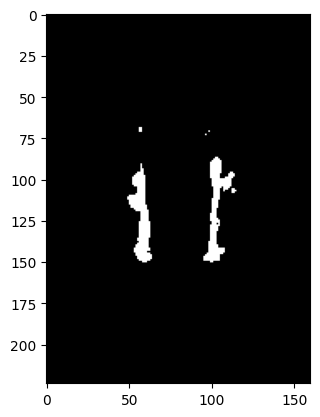

In [78]:
plt.imshow(y[17], cmap='gray')

In [79]:
from torch import no_grad

In [80]:
with no_grad():
    mean, samples = model.cuda().no_grad_mean_and_sample(x.cuda(), num_samples=12)

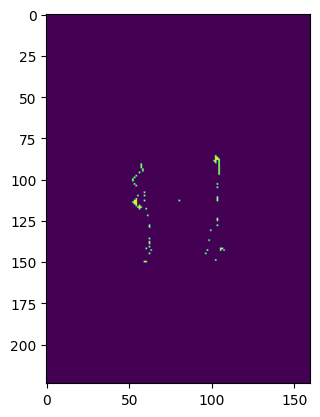

In [88]:
plt.imshow((samples[1][17].argmax(dim=0) != samples[4][17].argmax(dim=0)).cpu())

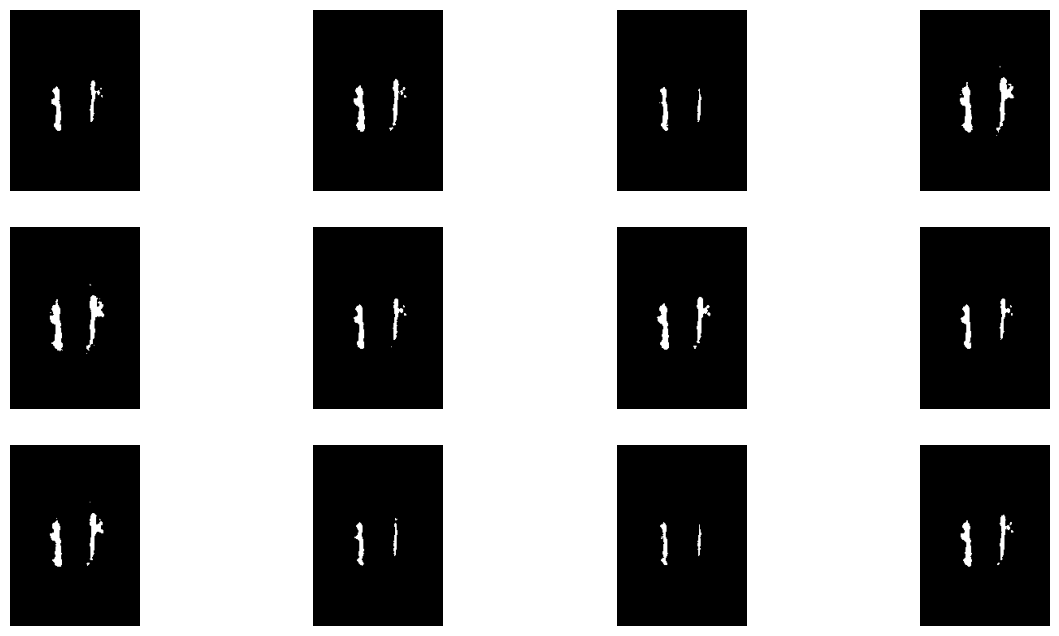

In [110]:
plt.figure(figsize=(15, 8))
for i in range(12):
    plt.subplot(3, 4, i+1)
    plt.imshow(samples[i][18].argmax(dim=0).cpu(), cmap='gray')
    plt.axis('off')

In [91]:
from trustworthai.utils.uncertainty_maps.entropy_map import entropy_map_from_samples

In [92]:
ent_map = entropy_map_from_samples(samples)

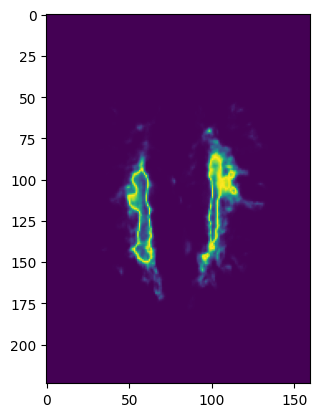

In [109]:
plt.imshow(ent_map[18].cpu())

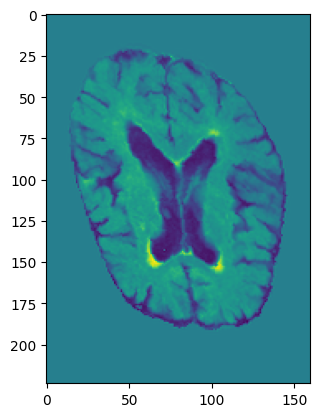

In [105]:
plt.imshow(x[12][0])

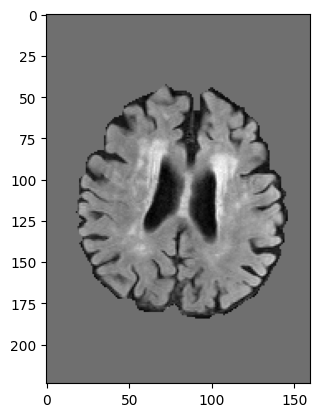

In [51]:
plt.imshow(x[10][0], cmap='gray')